# Assignment 3 (100 marks)

## *Generating useful features for further analysis on Amazon reviews*

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [19]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import gzip
import json
import string
import nltk # imports the natural language toolkit
import plotly
from nltk.corpus import stopwords
%matplotlib inline
nltk.download('punkt')

# We won't use this one this time
# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
# instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

Wall time: 3.75 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [20]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [21]:
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")

In [22]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1 (22 marks): 

#### 1.1 (4 marks)

Plot histograms of all numeric quantities for the `movies_tv` DataFrame. Note any observations (a few bullet points is fine). 

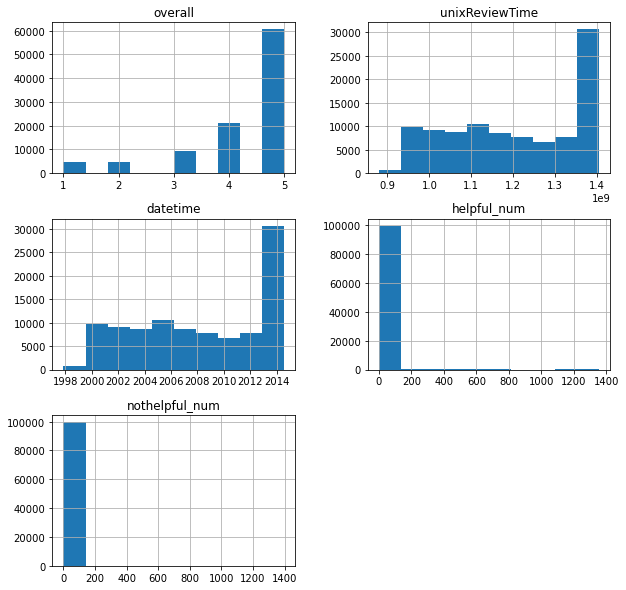

In [23]:
"""
Observations:
1. Most of the the overall rating is high, it indicate most of the movies and television are liked by customer.
2. The number of reviews increase sharply in 2014, more and more customer like watching movies and television and share their opinions.
3. Almost all of the number of helpful/not helpful is very small, it indicate these reviews is not very helpful for other customer.
"""
movies_tv['helpful_num'] = movies_tv['helpful'].apply(lambda x : x[0])
movies_tv['nothelpful_num'] = movies_tv['helpful'].apply(lambda x : x[1])
movies_tv.hist(figsize = (10, 10))
plt.show()


#### 1.2 (4 marks)

How do average ratings change over time in the `movies_tv` DataFrame? Plot the average rating for each year and note any trends (a few bullet points is fine). 

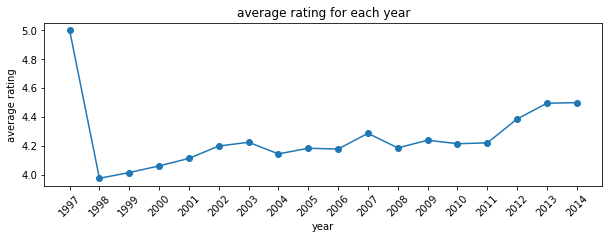

In [24]:
"""
Trends:
The average ratings fall sharply in 1998, then rose slowly over the next few years.
"""
movies_tv['year'] = movies_tv['datetime'].dt.year
mean_rating = movies_tv.groupby('year')['overall'].mean()
mean_rating.plot(figsize = (10, 3), ylabel = 'average rating', title = 'average rating for each year', marker='o')
plt.xticks(mean_rating.index)
plt.xticks(rotation = 45)
plt.show()


#### 1.3 (4 marks)

Plot the average length of the reviews in the `movies_tv` DataFrame for each year. Note any trends (a few bullet points is fine). 

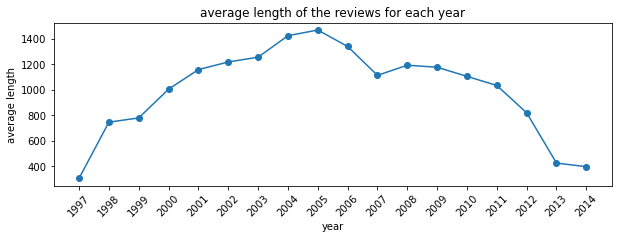

In [25]:
"""
Trends:
The average length of the reviews raise slowly before year 2005, but fall slowly after 2005.
"""
movies_tv['review_len'] = movies_tv['reviewText'].str.len()
mean_len = movies_tv.groupby('year')['review_len'].mean()
mean_len.plot(figsize = (10, 3), ylabel = 'average length', title = 'average length of the reviews for each year', marker='o')
plt.xticks(mean_len.index)
plt.xticks(rotation = 45)
plt.show()


#### 1.4 (10 marks)

We saw that movies and TV seem to have higher ratings in the 90s. Use a hypothesis test to determine if this is a statistically significant pattern. Specifically, 
- State the null and alternative hypotheses
- Run the appropriate hypothesis test in python
- Use the output to decide if you reject or fail to reject the null hypothesis 
- Interpret the p-value in this context 

In [26]:
"""
null hypothesis: the average ratings in the 90s is less or equal with other decades.
alternative hypothesis: the average ratings in the 90s is higher than other decades.
Reject the null hypothesis, as the p-value is less than 0.05
The p-value is 2.0552810822882246e-16, it indicate probability of assuming the null hypothesis is true is almost zero.
"""
movies_tv['decade'] = (movies_tv['year'] // 10) * 10
overall_90s = movies_tv[movies_tv['decade'] == 1990]['overall']
overall_other = movies_tv[movies_tv['decade'] != 1990]['overall']
pvalue = stats.ttest_ind(overall_90s, overall_other, equal_var=False).pvalue
pvalue


2.0552810822882246e-16

### Exercise 2 (10 marks): 

For the remainder of the assignment, we will use a smaller version of the `movies_tv` DataFrame given below:

In [27]:
short_movies_tv = movies_tv.head(10000)


Find the ten most frequently occurring non-stop words across: (i) all reviews, (ii) positive reviews (higher than 3 stars), (iii) (lower than 3 stars) negative reviews. 
Make a bar plot of the ten most frequently occurring words against their frequencies for each category ((i) (ii) and (iii)). What do you notice when comparing the graphs? Do the results surprise you? Why or why not? (A few bullet points is fine)

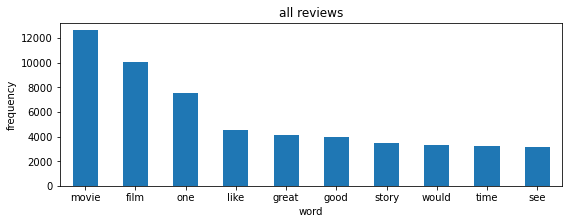

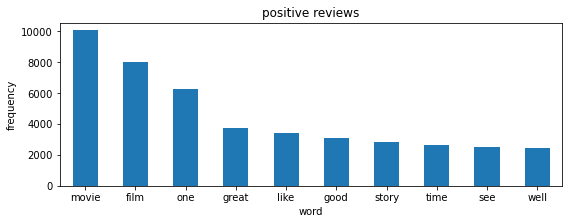

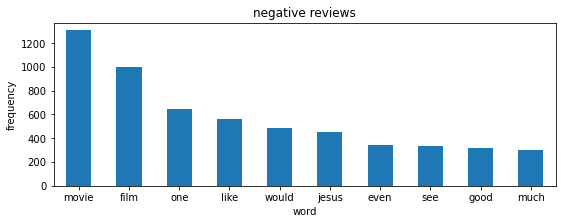

In [28]:
"""
When comparing the graphs, it can notice that the ten most frequently occurring non-stop words are very similar 
in category (i) (ii) and (iii).
Yes, the results surprise me, because most of the reviews use most of similar words regardless positive or negative reviews.
"""
def plot_top10_words(df, title):
    words = []
    for v in df.values:
        words += v
    df_words = pd.Series(words)
    top10 = df_words.value_counts().sort_values(ascending = False).head(10)
    plt.figure(figsize=(9, 3))
    top10.plot(kind='bar', rot=0, title = title, xlabel='word', ylabel='frequency')
def get_words(x):
    words = []
    for w in x:
        if w in stop_words:
            w = ''
        else:
            w = w.replace("'s",'').replace(',','').replace('"','').replace(':','').replace('.','').replace("''",'').replace("'",'').replace("-",'')
        if w and w not in stop_words:
            words.append(w)
    return words
short_movies_tv = short_movies_tv.assign(words = short_movies_tv['reviewText'].str.lower().str.split())
stop_words = stopwords.words('english')
short_movies_tv['words'] = short_movies_tv['words'].apply(lambda x: get_words(x))
plot_top10_words(short_movies_tv['words'], 'all reviews')
plot_top10_words(short_movies_tv[short_movies_tv['overall'] > 3]['words'], 'positive reviews')
plot_top10_words(short_movies_tv[short_movies_tv['overall'] < 3]['words'], 'negative reviews')
plt.show()


### Exercise 3 (8 marks):

Find 20 words that are indicative of bad reviews. That is, come up with a method to identify words that appear frequently in the bad reviews but do *not* occur frequently in the good reviews. What are these words? What do you observe about these words? Are they surprising?

In [29]:
'''
The words were mostly neutral, with no obvious negative emotions.
Yes, it surprising that bad reviews not use negative words frequently.
'''
def get_words_freq(df):
    words = []
    for v in df['words'].values:
        words += v
    df_words = pd.Series(words)
    return df_words.value_counts().sort_values(ascending = False)
bad_words = get_words_freq(short_movies_tv[short_movies_tv['overall'] < 3])
good_words = get_words_freq(short_movies_tv[short_movies_tv['overall'] > 3])
bad = list(bad_words.index[~bad_words.index.isin(good_words.index)].values)
for w in bad_words.index[bad_words.index.isin(good_words.index)]:
    if bad_words[w] > (good_words['w'] * 10):
        bad.append(w)
bad_words[bad_words.index.isin(bad)].head(20)


movie     1306
film      1001
one        643
like       564
would      487
jesus      455
even       339
see        331
good       319
much       301
really     298
people     287
story      282
christ     265
gibson     262
time       260
get        250
could      237
make       227
also       217
dtype: int64

### Exercise 4 (8 marks): 

Use the following code to inspect the first 50 1-star reviews from the `movies_tv` DataFrame containing the word "good". Discuss the most common ways the word good is used in these reviews. Are any of these informative or challenging for our analysis of what drives very negative reviews? 

In [30]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:50]:
    good_i = rev.lower().index("good")
    # we add Ansi codes to highlight the matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

1266
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of cor

**Answer.** <br>
Most common ways the word good is used:<br>
Word good is in negative statement to express it not meet their expection.<br>
Word good is used in partial affirmation, but disappoint in other.<br>

These are informative for our analysis of what drives very negative reviews.


### Exercise 5 (15 marks): 

For each review in the list of bad reviews containing the word "good" that we found in the last question (`good_word_bad_review`) extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

For example, "The popcorn at the movie was very good with butter." would have the solution

1. with
2. butter
3. movie

Print out the results for the first 15 reviews in the list `good_word_bad_review`. 

In [31]:
def is_noun_or_cardinal(tags, word):
    for token, tag in tags:
        if word == token and tag in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
            return True
    return False

def get_first_noun_or_cardinal(words, tags):
    for word in words:
        if is_noun_or_cardinal(tags, word):
            return word
    return ''

for review in good_word_bad_review[0:15]:
    review = review.replace('.', ' ')
    words = [w.lower() if w.lower() == 'good' else w for w in nltk.word_tokenize(review) if w[0:1].isalpha()]
    tags = nltk.pos_tag(words)    
    good_i = words.index('good')
    first_word = words[good_i + 1]
    first_noun_or_cardinal = get_first_noun_or_cardinal(words[good_i+1:], tags)
    last_noun_or_cardinal = get_first_noun_or_cardinal(words[0:good_i][::-1], tags)
    print((first_word, first_noun_or_cardinal, last_noun_or_cardinal))


('the', 'story', 'acting')
('but', 'scene', 'transfer')
('for', 'Edits', 'material')
('plot', 'plot', 'story')
('cinema', 'cinema', 'everything')
('and', 'history', 'acting')
('or', 'benefit', 'nothing')
('and', 'violent', 'flashbacks')
('because', 'filmmaker', 'symbol')
('to', 'extent', 'pain')
('review', 'review', 'film')
('and', 'lots', 'corse')
('film', 'film', 'anguish')
('music', 'music', 'riff')
('grief', 'grief', '')


### Exercise 6 (20 marks):

We have seen that individual words are not always very informative. Find the 20 most often occurring bigrams and trigrams in the (i) positive and (ii) negative reviews. Visualize the most frequently occurring bigrams and trigrams in (i) and (ii) and give a brief analysis of the n-grams you identified.

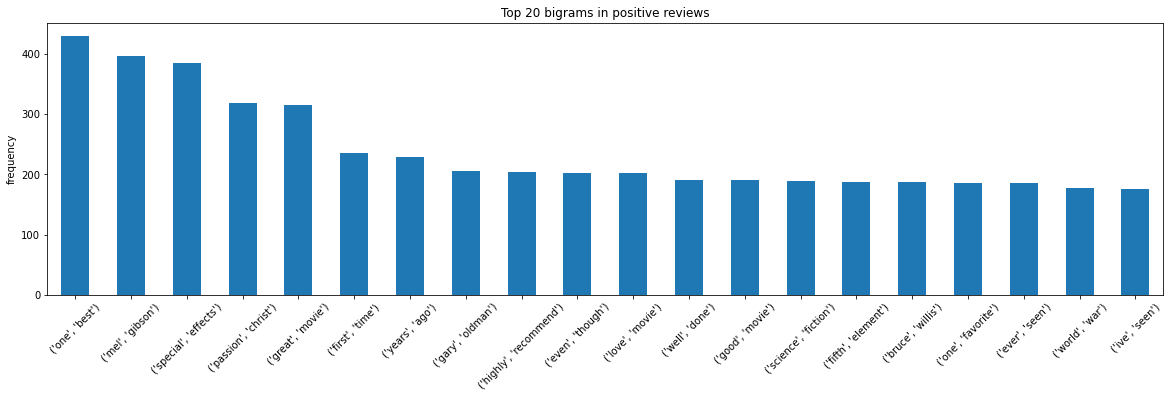

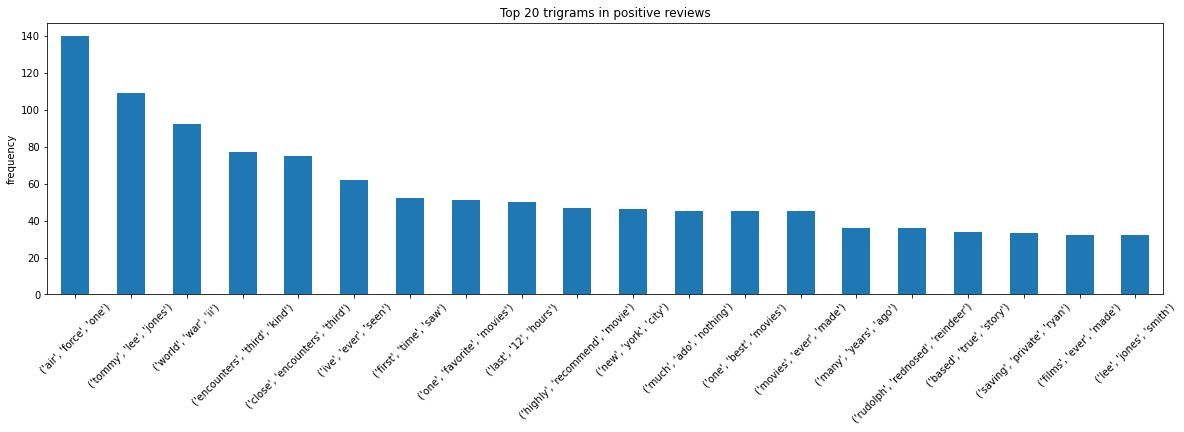

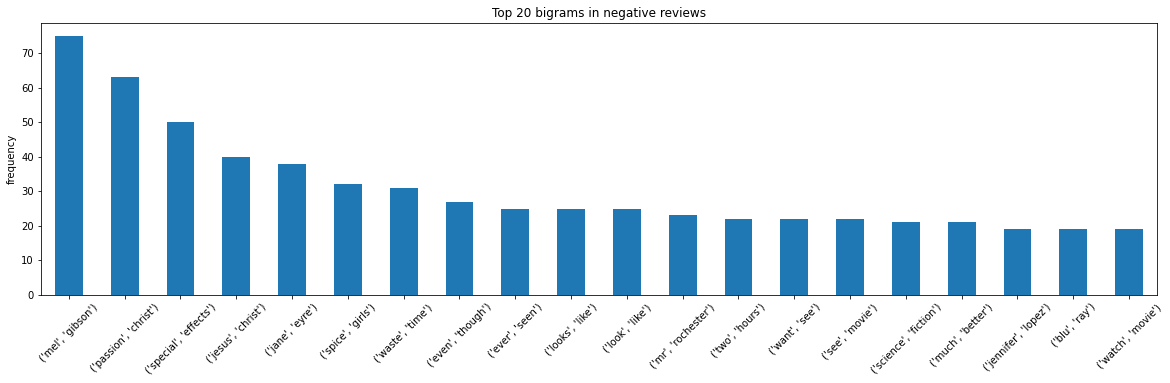

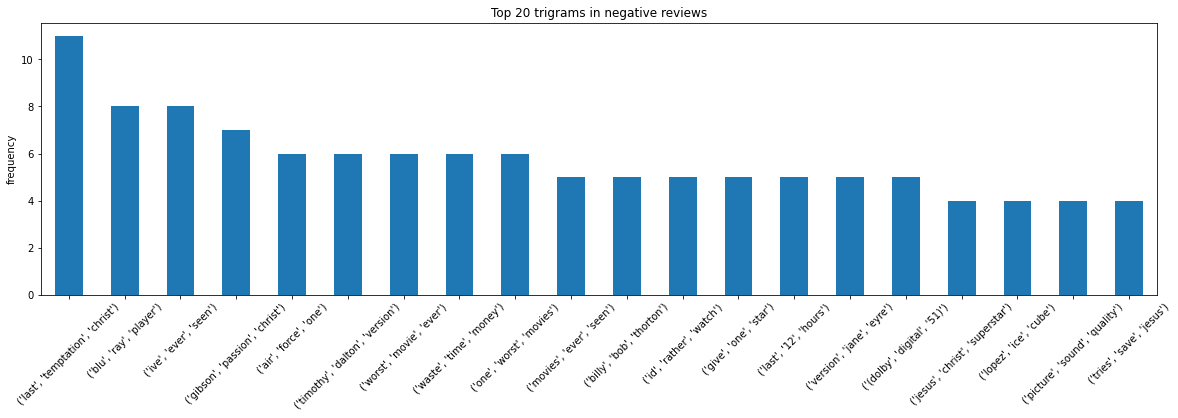

In [72]:
'''
Most frequently occurring bigrams and trigrams differ greatly between (i) positive reviews and (ii) negative reviews,
we can identify frequently used phrases in positive and negative reviews,
'''
from nltk.util import bigrams, trigrams
def plot_data(title, df):
    plt.figure(figsize=(20, 5))
    df.plot(title = title, ylabel = 'frequency', kind = 'bar', rot = 45)
    plt.xticks(range(len(df.index)), df.index)
    
def plot_ngrams(df, title):
    bigrams_list = []
    trigrams_list = []
    for words in df['words']:
        bigrams_list += list(bigrams(words))
        trigrams_list += list(trigrams(words))
    bigrams_df = pd.DataFrame({'b': bigrams_list})
    trigrams_df = pd.DataFrame({'t': trigrams_list})    
    bigrams_top = bigrams_df['b'].value_counts().sort_values(ascending = False).head(20)
    trigrams_top = trigrams_df['t'].value_counts().sort_values(ascending = False).head(20)
    plot_data('Top 20 bigrams in {}'.format(title), bigrams_top)
    plot_data('Top 20 trigrams in {}'.format(title), trigrams_top)
    
positive_reviews = short_movies_tv[short_movies_tv['overall'] > 3]
negative_reviews = short_movies_tv[short_movies_tv['overall'] < 3]
plot_ngrams(positive_reviews, 'positive reviews')
plot_ngrams(negative_reviews, 'negative reviews')
plt.show()


### Exercise 7 (8 marks): 

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words. (You do not need to implement your method.)

**Answer.**<br>
We can extract these informative words by the most often occurring n-grams, combine with each word's frequency, like following steps:<br>
(1) Find the 20 most often occurring bigrams and trigrams<br>
(2) For these words in above bigrams and trigrams, get their frequency in (i) positive and (ii) negative reviews.<br>
(3) Get informative words which are more frequently occurs in positive reviews or negative positive.<br>


### Exercise 8 (9 marks): 

Write a function(s) that transforms a document into a list of adjective-noun pairs. 
- For each sentence in the document, find each adjective in the sentence and find the first noun that follows it in the sentence. Combine the adjective with the noun in a string that has the format "adjective noun". 
- For example, the document "That was a good, long movie" should return `["good movie", "long movie"]`. If no nouns appear after an adjective, do not add that adjective to the output list. 
- Demonstrate your function works on the first review in `short_movies_tv` and the sentence "The big black dog scared the red cat."

In [93]:
import nltk
def get_adjective_noun_pairs(sentence):
    pairs = []
    words = nltk.word_tokenize(sentence)
    tags = nltk.pos_tag(words)
    adjs = []
    for word, tag in tags:
        if tag in ['JJ', 'JJR', 'JJS']:
            adjs.append(word)
        elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            for adj in adjs:
                pairs.append('{} {}'.format(adj, word))
            adjs = []
    return pairs
print(get_adjective_noun_pairs(short_movies_tv['reviewText'].head(1).values[0]))
print(get_adjective_noun_pairs("The big black dog scared the red cat."))


['charming version', 'classic Dicken', 'good showing', 'better average']
['big dog', 'black dog', 'red cat']
